# Pairwise Comparison for Single Environment

In this file we do a pairwise comparison for policies trained in a single environment but using different seeds and/or training algorithms.

We look at:

- Self-play
- Cross-play between policies trained with the same algorithm but different seeds
- Cross-play between policies trained with different algorithms


## Notation

- **Self-play** refers to pairings of policies that trained together
- **Cross-play** refers to pairings of policies that were not trained together

In [1]:
import os.path as osp
from typing import List

import pandas
import numpy as np
import matplotlib.pyplot as plt

import posggym

import exp_utils
from plot_utils import heatmap, annotate_heatmap

# Data Loading

Firstly lets load the data and do a little cleaning and setup by:

1. removing unused columns
2. add columns for agent policy training environment and reasoning level

In [2]:
rl_policies_results_dir_name = '2022-05-29 03:19:51.564867'
rl_policies_results_file = osp.join(exp_utils.EXP_RESULTS_DIR, rl_policies_results_dir_name, "compiled_results.csv")
df = pandas.read_csv(rl_policies_results_file)

columns_to_drop = [
    'Unnamed: 0', 
    'episode_step_limit', 
    'time_limit', 
    'search_time_mean', 
    'search_time_std', 
    'update_time_mean', 
    'update_time_std',
    'reinvigoration_time_mean', 
    'reinvigoration_time_std', 
    'policy_calls_mean', 
    'policy_calls_std', 
    'inference_time_mean', 
    'inference_time_std',
    'episode_dones', 
    # 'num_outcome_LOSS', 
    # 'num_outcome_DRAW', 
    # 'num_outcome_WIN', 
    # 'num_outcome_NA'
]
df = df.drop(columns_to_drop, axis=1)

# Add 95% CI
def conf_int(row, prefix):
    std = row[f"{prefix}_std"]
    n = row["num_episodes"]
    return 1.96 * (std / np.sqrt(n))

prefix = ""
for col in df.columns:
    if not col.endswith("_std"):
        continue
    prefix = col.replace("_std", "")
    df[f"{prefix}_CI"] = df.apply(
        lambda row: conf_int(row, prefix), axis=1
    )

df.columns

Index(['exp_id', 'agent_id', 'env_name', 'seed', 'num_episodes', 'policy_name',
       'policy_dir', 'policy_id', 'episode_returns_mean',
       'episode_returns_std', 'episode_returns_max', 'episode_returns_min',
       'episode_discounted_returns_mean', 'episode_discounted_returns_std',
       'episode_discounted_returns_max', 'episode_discounted_returns_min',
       'episode_steps_mean', 'episode_steps_std', 'episode_times_mean',
       'episode_times_std', 'num_outcome_LOSS', 'num_outcome_DRAW',
       'num_outcome_WIN', 'num_outcome_NA', 'episode_returns_CI',
       'episode_discounted_returns_CI', 'episode_steps_CI',
       'episode_times_CI'],
      dtype='object')

In [3]:
df["policy_dir"].unique()

array(['/home/remote/u1078789/baposgmcp_results/Driving/rl_policies/train_klr_Driving7x7RoundAbout-v0_k=4_seed=1_2022-05-28 04:14:40.698742',
       '/home/remote/u1078789/baposgmcp_results/Driving/rl_policies/train_klr_Driving7x7RoundAbout-v0_k=4_seed=2_2022-05-28 04:14:41.758780',
       '/home/remote/u1078789/baposgmcp_results/Driving/rl_policies/Driving7x7RoundAbout-v0_SP_4_2022-05-27 04:17:29.496897',
       '/home/remote/u1078789/baposgmcp_results/Driving/rl_policies/train_klr_Driving7x7RoundAbout-v0_k=4_seed=3_2022-05-28 04:16:25.641427',
       '/home/remote/u1078789/baposgmcp_results/Driving/rl_policies/train_klr_Driving7x7RoundAbout-v0_k=4_seed=0_2022-05-28 04:06:27.435078',
       '/home/remote/u1078789/baposgmcp_results/Driving/rl_policies/train_klr_Driving7x7RoundAbout-v0_k=4_seed=4_2022-05-28 04:09:40.687571',
       '/home/remote/u1078789/baposgmcp_results/Driving/rl_policies/Driving7x7RoundAbout-v0_SP_2_2022-05-27 04:16:49.058201',
       '/home/remote/u1078789/baposgmc

In [6]:
def rename_policy_dir(row):
    policy_dir = row["policy_dir"]
    policy_dir = osp.basename(osp.normpath(policy_dir))
    if policy_dir.startswith("Driving7x7RoundAbout-v0_SP"):
        seed = int(policy_dir.split("_")[2])
        timestamp = policy_dir.split("_")[3]
        policy_dir = f"train_sp_Driving7x7RoundAbout-v0_seed={seed}_{timestamp}"
    return policy_dir

df["policy_dir"] = df.apply(rename_policy_dir, axis=1)
policy_dirs = df["policy_dir"].unique()
policy_dirs.sort()

policy_dirs


array(['train_klr_Driving7x7RoundAbout-v0_k=4_seed=0_2022-05-28 04:06:27.435078',
       'train_klr_Driving7x7RoundAbout-v0_k=4_seed=1_2022-05-28 04:14:40.698742',
       'train_klr_Driving7x7RoundAbout-v0_k=4_seed=2_2022-05-28 04:14:41.758780',
       'train_klr_Driving7x7RoundAbout-v0_k=4_seed=3_2022-05-28 04:16:25.641427',
       'train_klr_Driving7x7RoundAbout-v0_k=4_seed=4_2022-05-28 04:09:40.687571',
       'train_sp_Driving7x7RoundAbout-v0_seed=0_2022-05-27 04:17:30.967495',
       'train_sp_Driving7x7RoundAbout-v0_seed=1_2022-05-27 04:16:44.295582',
       'train_sp_Driving7x7RoundAbout-v0_seed=2_2022-05-27 04:16:49.058201',
       'train_sp_Driving7x7RoundAbout-v0_seed=3_2022-05-27 04:16:59.789268',
       'train_sp_Driving7x7RoundAbout-v0_seed=4_2022-05-27 04:17:29.496897'],
      dtype=object)

In [7]:
def get_k(row):
    pi_name = row["policy_name"]
    if "Random" in pi_name:
        return str(-1)
    try:
        return pi_name.split("_")[-1]
    except Exception:
        raise Exception("Policy name error")
        

def get_train_properties(row):
    if "policy_dir" not in row:
        return 'None', 'None', 'None'
    
    policy_dir = row["policy_dir"]
    if policy_dir in (None, 'None', np.nan):
        # random or some other fixed policy
        return 'None', 'None', 'None'
    
    # get only final directory in path
    policy_dir = osp.basename(osp.normpath(policy_dir))
    
    # expect 'train_<alg>_<env_name>_[seed=int]_<timestamp>'
    tokens = policy_dir.split("_")
    alg = tokens[1]
    env_name = tokens[2]
    
    if alg.lower() == "klr":
        # expect 'train_<alg>_<env_name>_k=<k>_[seed=int]_<timestamp>'
        seed_idx = 4
    else:
        seed_idx = 3
    
    seed = 'None' if "seed=" not in policy_dir else int(tokens[seed_idx].split("=")[1])
    return alg, env_name, seed


def get_train_alg(row):
    return get_train_properties(row)[0]


def get_train_env(row):
    return get_train_properties(row)[1]


def get_train_seed(row):
    return get_train_properties(row)[2]
    

df["K"] = df.apply(get_k, axis=1)
df["train_env_name"] = df.apply(get_train_env, axis=1)
df["train_seed"] = df.apply(get_train_seed, axis=1)
df["train_alg"] = df.apply(get_train_alg, axis=1)

# Plotting

For this evaluation we have multiple degrees of variation:

1. Test environment ('env_name') - the environment the experiment was run in 
2. Policy train environment ('train_env_name') - the environment an agent policy was trained on
3. Policy reasoning level ('K') - the reasoning level of an agent policy
4. Train Seeds ('train_seed') - the training seed of the agent policy
5. Training algorithm ('train_alg') - The algorithm used to train the agent policy


In [8]:
# some sanity tests
test_envs = df["env_name"].unique()
train_envs = df["train_env_name"].unique()
assert len(test_envs) == 1
assert len(train_envs) == 1
test_env = test_envs[0]
train_env = train_envs[0]
assert test_env == train_env

agent_ids = df["agent_id"].unique()
agent_ids.sort()
assert len(agent_ids) == 2
agent_0_id = agent_ids[0]
agent_1_id = agent_ids[1]

print("Test Env:", test_env)
print("Train Envs:", train_env)
print("Agent IDs:", agent_ids)
print("Policy K:", df["K"].unique())
print("Train Seeds:", df["train_seed"].unique())
print("Train Algorithms:", df["train_alg"].unique())


Test Env: Driving7x7RoundAbout-v0
Train Envs: Driving7x7RoundAbout-v0
Agent IDs: [0 1]
Policy K: ['4' '-1' 'SP' '2' '3' '0' '1' 'BR']
Train Seeds: [1 2 4 3 0]
Train Algorithms: ['klr' 'sp']


## The environment

Here we can see the layout for the different environment. Noting that the start and destination positions for each agent changes each episode. Agents always start in a cell along the bottom or right side of the grid and have a destination in a cell along the top or left side of the grid.  

Agents can observe a rectangular area around their current location that that contains 3 cells in front, 1 behind and 1 cell to each side (total 4x3=12 cells), shown by the highlighted cells in the images. 

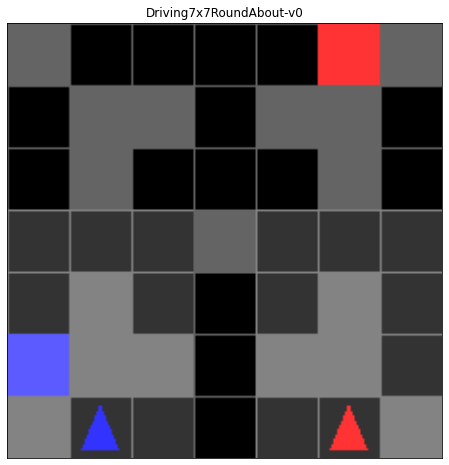

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
# Turn off x/y axis numbering/ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.set_xticklabels([])
ax.set_yticklabels([])

env = posggym.make(test_env)
env_img, _ = env.render(mode='rgb')

imshow_obj = ax.imshow(
    env_img, interpolation='bilinear', origin='upper'
)
imshow_obj.set_data(env_img)

ax.set_title(test_env)
    
plt.show()
    

## Helper Functions

The following are some helper functions for later plots.

In [10]:
def get_pw_pi_returns(plot_df,
                      row_pi: str,
                      col_pi: str):
    """Get pairwise performance between two policies for every seed."""
    row_df = plot_df[(plot_df["K"] == row_pi)]
    row_exp_ids = row_df["exp_id"]
    
    col_df = plot_df[
        (plot_df["K"] == col_pi)
        & (plot_df["exp_id"].isin(row_exp_ids))
    ]
    
    plot_df = plot_df[plot_df["exp_id"].isin(col_df["exp_id"])]
    row_df = plot_df[plot_df["K"] == row_pi]
    col_df = plot_df[plot_df["K"] == col_pi]
    
    row_seeds = row_df["train_seed"].unique()
    row_seeds.sort()
    col_seeds = col_df["train_seed"].unique()
    col_seeds.sort()

    pw_returns = np.zeros((len(row_seeds), len(col_seeds)))

    for c, col_seed in enumerate(col_seeds):
        col_seed_df = plot_df[
            (plot_df["K"] == col_pi)
            & (plot_df["train_seed"] == col_seed)
        ]
        col_seed_exp_ids = col_seed_df["exp_id"]
        for r, row_seed in enumerate(row_seeds):
            row_seed_df = plot_df[
                (plot_df["K"] == row_pi)
                & (plot_df["train_seed"] == row_seed)
                & (plot_df["exp_id"].isin(col_seed_exp_ids))
            ]
            y = row_seed_df["episode_discounted_returns_mean"]
            if len(y) == 0:
                # do this so we can see where error is
                y = np.nan
            elif len(y) > 1:
                y = y.mean()
            
            pw_returns[r][c] = y
    
    return (row_seeds, col_seeds), pw_returns


def get_pw_pi_mean_returns(plot_df,
                           row_pi: str,
                           col_pi: str,
                           cross_play_only: bool):
    """Get pairwise performance between two policies averaged across 
    same seed (self-play) and different seeds (cross-play).
    """
    seeds, pw_returns = get_pw_pi_returns(plot_df, row_pi, col_pi)
    
    cross_play_values = []
    self_play_values = []
    for r, row_seed in enumerate(seeds[0]):
        for c, col_seed in enumerate(seeds[1]):
            v = pw_returns[r][c]
            if np.isnan(v):
                continue
            if row_seed == col_seed and not cross_play_only:
                self_play_values.append(v)
            else: 
                cross_play_values.append(v)
    if cross_play_only:
        return np.nan, np.mean(cross_play_values)
    
    return np.mean(self_play_values), np.mean(cross_play_values)


def get_all_pw_mean_returns(plot_df):
    policy_IDs = plot_df["K"].unique()
    policy_IDs.sort()
    
    xp_pw_returns = np.zeros((len(policy_IDs), len(policy_IDs)))
    sp_pw_returns = np.zeros((len(policy_IDs), len(policy_IDs)))

    for c, col_policy_id in enumerate(policy_IDs):
        col_agent_df = plot_df[
            (plot_df["K"] == col_policy_id)
        ]
        col_agent_alg = list(col_agent_df["train_alg"].unique())[0]
        for r, row_policy_id in enumerate(policy_IDs):
            row_agent_df = plot_df[
                (plot_df["K"] == row_policy_id)
            ]
            row_agent_alg = list(row_agent_df["train_alg"].unique())[0]
            
            sp_return, xp_return = get_pw_pi_mean_returns(
                plot_df, col_policy_id, row_policy_id, col_agent_alg != row_agent_alg
            )

            sp_pw_returns[r][c] = sp_return
            xp_pw_returns[r][c] = xp_return
    
    return policy_IDs, sp_pw_returns, xp_pw_returns


In [37]:
def plot_pw_heatmap(ax,
                    pi_labels,
                    pw_returns,
                    title=None,
                    vrange=None):
    # Note numpy arrays by default have (0, 0) in the top-left corner
    # While matplotlib images are displayed with (0, 0) being the bottom-left corner
    # To get images looking correct we need to reverse the rows of the array
    # And also the row labels
    pw_returns = pw_returns.T
    pw_returns = pw_returns[-1::-1]
    
    if vrange is None:
        vrange = (-0.2, 1.0)
    
    im, cbar = heatmap(
        data=pw_returns, 
        row_labels=reversed(pi_labels[0]),
        col_labels=pi_labels[1],
        ax=ax,
        show_cbar=False,
        cmap="viridis",
        vmin=vrange[0],
        vmax=vrange[1]
    )
    texts = annotate_heatmap(
        im, 
        valfmt="{x:.2f}",
        textcolors=("white", "black"),
        threshold=0.2
    )
    if title:
        ax.set_title(title)

##  Performance by seed 

Here we look at the pairwise performance for each training population policy (distinct policy within the same training algorithm) with different seeds. This leads to a 3D heatmap figure, where each heatmap shows a policy pairing across all seed pairings.

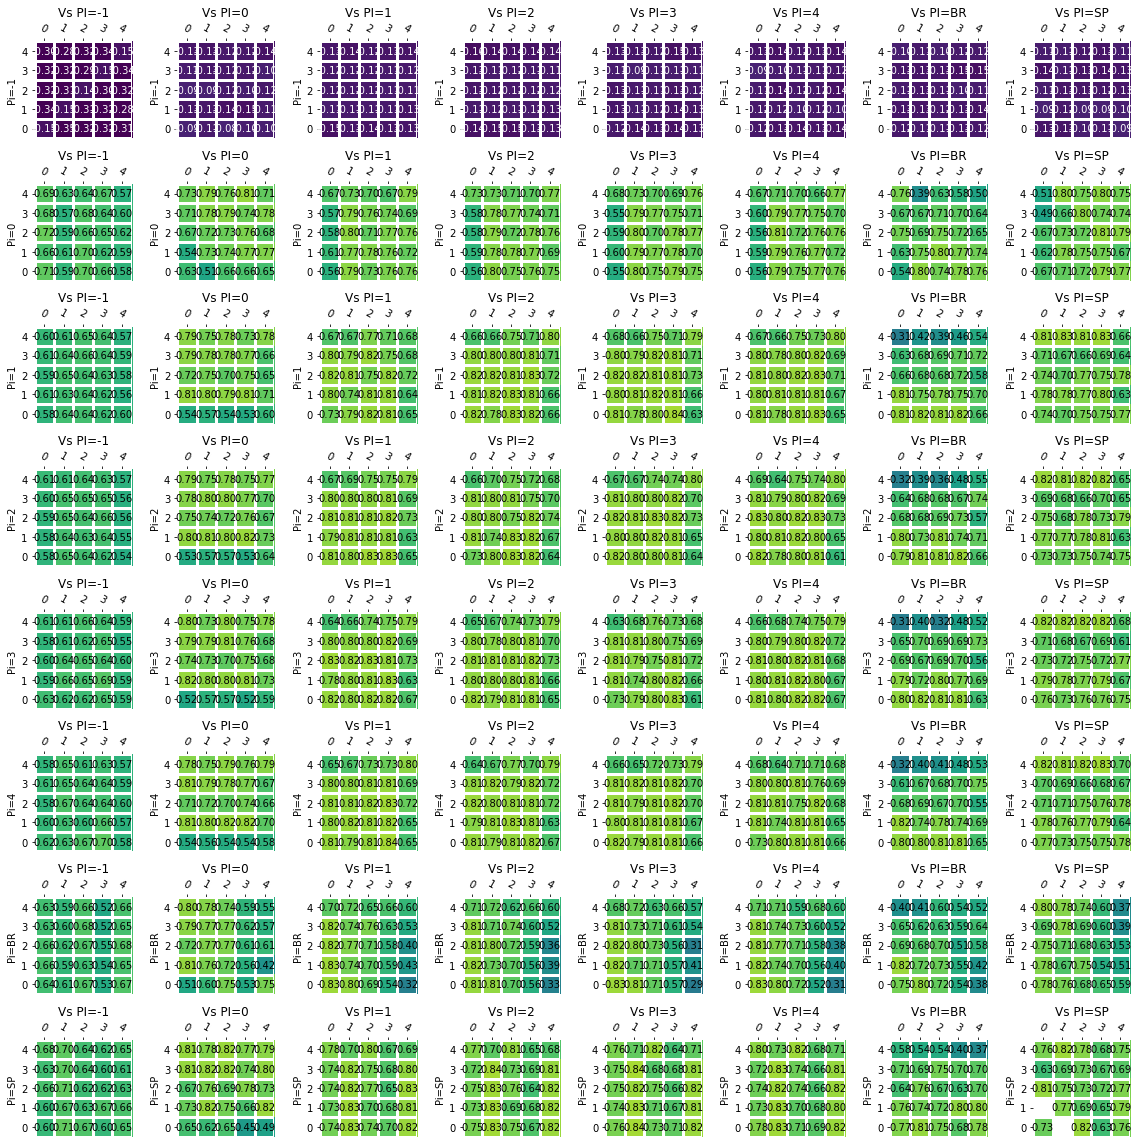

In [21]:
policy_IDs = df["K"].unique()
policy_IDs.sort()

fig, axs = plt.subplots(nrows=len(policy_IDs), ncols=len(policy_IDs), figsize=(16, 16))
for r, row_policy_id in enumerate(policy_IDs):
    for c, col_policy_id in enumerate(policy_IDs):
        ax = axs[r][c]
        seeds, pw_returns = get_pw_pi_returns(df, row_policy_id, col_policy_id)
        if len(seeds[0]) == 0 or len(seeds[1]) == 0:
            continue
        plot_pw_heatmap(ax, seeds, pw_returns, title=f"Vs PI={col_policy_id}")
        ax.set_ylabel(f"Pi={row_policy_id}")

fig.tight_layout()
# fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "pw_rl_performance.png"))
plt.show()

## Mean Performance

We next look at average performance for self-play (same algorithm and training seed) and cross-play (different algorithm and/or training seed).

The right-hand most plot shows the difference between self-play and cross-play performance. This difference is the generalization gap.

(-0.2, 1.0)
(-0.2, 1.0)
(-0.04552969256908135, 0.170823582963982)


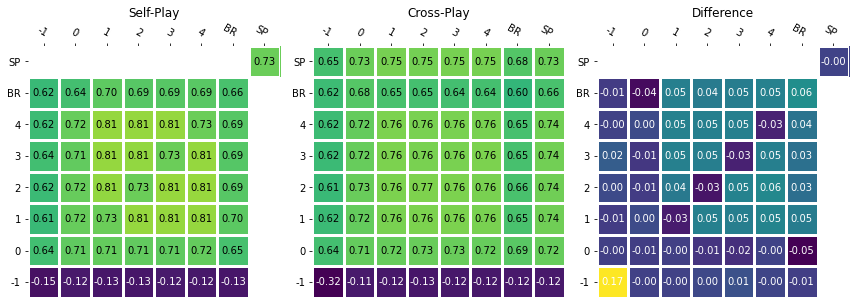

In [36]:
policy_ids, sp_pw_returns, xp_pw_returns = get_all_pw_mean_returns(df)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
plot_pw_heatmap(axs[0], (policy_ids, policy_ids), sp_pw_returns, title=f"Self-Play")
plot_pw_heatmap(axs[1], (policy_ids, policy_ids), xp_pw_returns, title=f"Cross-Play")

pw_diff = sp_pw_returns - xp_pw_returns
plot_pw_heatmap(
    axs[2], (policy_ids, policy_ids), pw_diff, title=f"Difference", vrange=(np.nanmin(pw_diff), np.nanmax(pw_diff))
)

fig.tight_layout()
# fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "pw_rl_performance.png"))
plt.show()